# **Aprendizaje estructural de una Red Bayesiana para relacionar los factores implicados en enfermedades cardiovasculares usando HC**

## Contexto

Las enfermedades cardiovasculares (ECV) son la principal causa de muerte en todo el mundo, representando un 32% de todas las muertes anuales [OMS](https://www.who.int/news-room/fact-sheets/detail/cardiovascular-diseases-(cvds)). Los factores de riesgo más comunes para desarrollar enfermedades del corazón incluyen una dieta poco saludable, la inactividad física, el consumo de tabaco y el abuso del alcohol. Estos factores pueden llevar a problemas como presión arterial elevada, niveles elevados de glucosa y colesterol en sangre, así como sobrepeso y obesidad.

Los factores de riesgo para las ECV se dividen en dos categorías: modificables (aquellos influenciados por el estilo de vida) y no modificables (como la edad o los antecedentes familiares). Mientras que los factores no modificables no pueden alterarse, los factores modificables pueden ser controlados a través de intervenciones y cambios en el estilo de vida, lo que ofrece una oportunidad significativa para la prevención de enfermedades cardiovasculares. En este notebook determinaremos una red bayesiana que modele la relación de estos factores de riesgo y la enfermedad cardiovascular.

Este trabajo está inspirado en el trabajo realizado por Luca Tesdechini y Matteo Fasulo [Repositorio de GitHub](https://github.com/MatteoFasulo/BayesianHeartDisease/tree/1b33ef0755b268d5fc2e9b6403071ab1704bcdc).

## Descripción del dataset

Antes de describir el dataset, procedemos a importar todas las librerías necesarias para poder desarrollar el notebook

In [29]:
#Matplotlib and networkx are used to plot the graph
import matplotlib.pyplot as plt
import networkx as nx

#Essential python libraries
import numpy as np
import pandas as pd

#Pgmpy modules used throughout the code
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import HillClimbSearch, MaximumLikelihoodEstimator

#Sklearn modules used throughout the code to work with the data
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

Trabajaremos con un dataset relacionado con factores de riesgo de enfermedades del corazón. Este dataset contiene las siguientes variables, discretizadas de la siguiente manera:

* **Age**: Edad del paciente (años).
    * 20-40, 40-50, 50-60, 60-70, 70+.
  
* **Sex**: Sexo del paciente.
    * M: Masculino.
    * F: Femenino.

* **ChestPainType**: Tipo de dolor torácico.
    * TA: Angina típica.
    * ATA: Angina atípica.
    * NAP: Dolor no anginoso.
    * ASY: Asintomático.

* **RestingBP**: Presión arterial en reposo (mm Hg), discretizada en:
    * 90-120, 120-140, 140+.

* **Cholesterol**: Colesterol sérico (mg/dl), discretizado en:
    * <=200, 200-240, 240+.

* **FastingBS**: Azúcar en ayunas.
    * N: Si el nivel de azúcar en ayunas <= 120 mg/dl.
    * Y: Si el nivel de azúcar en ayunas > 120 mg/dl.

* **RestingECG**: Electrocardiograma en reposo.
    * Normal: Normal.
    * ST: Anomalías en la onda ST-T.
    * LVH: Hipertrofia ventricular izquierda.

* **MaxHR**: Máxima frecuencia cardíaca alcanzada, discretizada en 4 grupos:
    * low, medium, high, very-high (utilizando cuartiles).

* **ExerciseAngina**: Angina inducida por ejercicio.
    * Y: Sí.
    * N: No.

* **Oldpeak**: Depresión ST medida durante el esfuerzo físico, discretizada en:
    * <=0.5, 0.5-1, 1-2, 2+.

* **ST_Slope**: Pendiente del segmento ST.
    * Up: Ascendente.
    * Flat: Plana.
    * Down: Descendente.

* **HeartDisease**: Enfermedad del corazón.
    * 1: Indica enfermedad del corazón.
    * 0: Normal.


In [30]:
data = pd.read_csv('heart.csv')
print("El dataset contiene %s observaciones y %s atributos" % data.shape)
data.head()

El dataset contiene 746 observaciones y 12 atributos


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,20-40,M,ATA,120-140,240+,N,Normal,very-high,N,<=0.5,Up,0
1,40-50,F,NAP,140+,<=200,N,Normal,high,N,0-5-1,Flat,1
2,20-40,M,ATA,120-140,240+,N,ST,low,N,<=0.5,Up,0
3,40-50,F,ASY,120-140,200-240,N,Normal,low,Y,1-2,Flat,1
4,50-60,M,NAP,140+,<=200,N,Normal,low,N,<=0.5,Up,0


## Algoritmo HC

El algoritmo HC es un método de búsqueda heurística utilizado para aprender la estructura de una Red Bayesiana. Parte de una red vacía (o una ya existente) y realiza modificaciones iterativas (agregar, eliminar o revertir arcos) para maximizar una puntuación de calidad.

En este trabajo, evaluaremos las dos métricas estudiadas en el TFG para guiar el aprendizaje:

    Criterio de Información de Akaike (AIC):
    Combina la probabilidad del modelo con una penalización basada en la complejidad del mismo.

    Criterio de Información Bayesiano (BIC):
    Similar al AIC, pero con una penalización mayor para modelos más complejos.

Dado que HC es un algoritmo de búsqueda local, puede quedar atrapado en óptimos locales. Para mitigar esto, se ejecutará el algoritmo varias veces con diferentes inicializaciones, seleccionando al final la mejor red obtenida según las métricas.

Usaremos la biblioteca [pgmpy](https://github.com/pgmpy/pgmpy)  para implementar este algoritmo con las distintas métricas.

In [31]:
## Función para ejecutar distintos estructuras iniciales

kfold = KFold(5, shuffle=True, random_state=42)
target_variable = "HeartDisease"

def bayesian_kfold(df, model, metric):
    score = []
    predictions = []
    for train, test in kfold.split(df):
        model.cpds = []
        model.fit(df.iloc[train, :], estimator=MaximumLikelihoodEstimator)
        y_pred = model.predict(df.drop(columns=target_variable, axis=1).iloc[test, :])
        score.append(
            metric(df[target_variable].iloc[test], y_pred[target_variable]))
        predictions.append(y_pred)
    return sum(score) / len(score), predictions[0]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

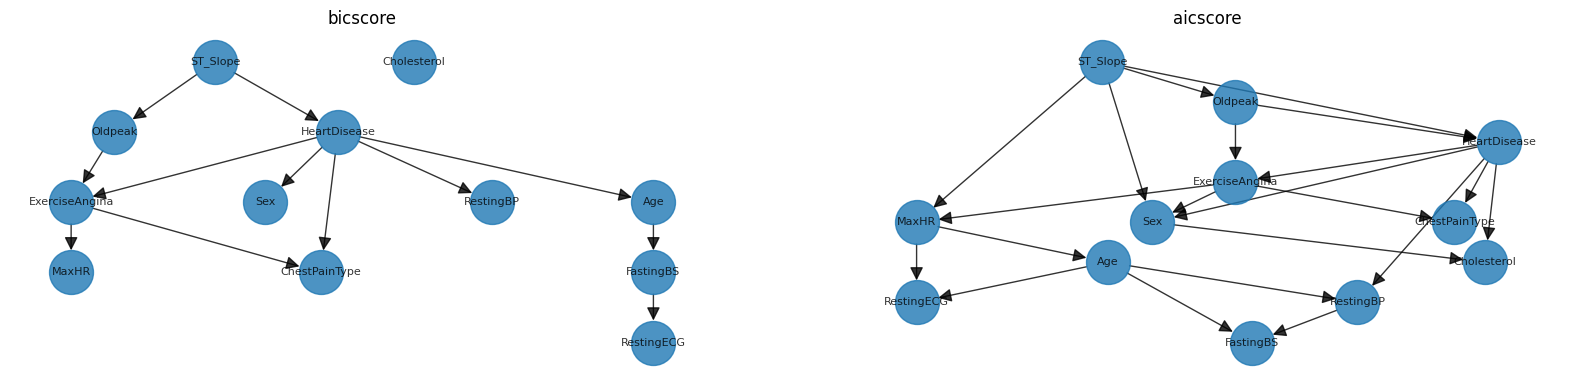

In [32]:
scores = {} # Dictionary to store the accuracy_score for each scoring method
networks = {} # Dictionary to store the network structure for each scoring method

for scoring in ['bicscore', 'aicscore']:
    network = HillClimbSearch(data, use_cache=False).estimate(scoring_method=scoring)
    networks[scoring] = network
    model = BayesianNetwork(network)
    scores[scoring], _ = bayesian_kfold(data, model, accuracy_score)

fig = plt.figure(figsize=(20,15))
i = 1
for scoring in networks:
    plt.subplot(3,2,i)
    pos = nx.nx_agraph.graphviz_layout(networks[scoring], prog="dot")
    nx.draw(networks[scoring], pos, with_labels=True, node_size=1000,
        font_size=8, arrowsize=20, alpha=0.8)
    plt.title(scoring)
    i += 1
plt.show()

Como vemos, obtenemos dos representaciones distintas de la Red Bayesiana, una por cada medida de calidad empleada (izquierda, BIC, derecha, AIC).

Finalmente, evaluamos qué métrica de calidad representa de manera más adecuada el conjunto de datos:

In [33]:
pd.DataFrame(scores, index = ['ACCURACY'])

,bicscore,aicscore
ACCURACY,0.852501,0.856501


 Ambas medidas, AIC y BIC, muestran un desempeño similar en la representación del modelo. Sin embargo, al analizar los resultados, observamos que la métrica AIC ofrece una representación ligeramente superior en términos de ajuste al conjunto de datos.